In [176]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from itertools import product

import os

In [177]:
df = pd.read_csv('./res/train_df.csv')
image = cv2.imread('./res/train_imgs/001-1-1-01-Z17_A-0000001.jpg', cv2.COLOR_BGR2RGB)
inputs = tf.expand_dims(image, 0)

In [196]:
df.iloc[:, 1:].iloc[:, ::2].min().min()

484.71572440839975

In [201]:
df.iloc[:, 1:].iloc[:, ::2].max().max()

1440.2047919689292

In [198]:
image.shape

(1080, 1920, 3)

In [203]:
1920 - (1080)/2

1380.0

In [204]:
(1080)/2

540.0

In [194]:
df.iloc[:, 1:].iloc[:, 1::2].min().min()

160.46791743853043

In [195]:
df.iloc[:, 1:].iloc[:, 1::2].max().max()

969.317126766628

In [3]:
# plt.imshow(image)
# plt.axis('off')
# plt.show()

In [23]:
df['x_min'] = df.iloc[:, 1:49:2].apply(lambda x: int(min(x)), axis=1)
df['x_max'] = df.iloc[:, 1:49:2].apply(lambda x: int(max(x)), axis=1)
df['y_min'] = df.iloc[:, 2:49:2].apply(lambda x: int(min(x)), axis=1)
df['y_max'] = df.iloc[:, 2:49:2].apply(lambda x: int(max(x)), axis=1)

In [24]:
df.tail()

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y,x_min,x_max,y_min,y_max
4190,642-2-4-31-Z148_E-0000023.jpg,637.251052,781.34226,1117.135818,370.667301,1097.123228,330.6422,1095.455539,355.657874,1083.3646,...,805.273267,541.608226,630.99709,612.486105,616.404617,803.439462,616,1117,192,890
4191,642-2-4-31-Z148_E-0000025.jpg,637.251052,781.34226,1117.135818,370.667301,1097.123228,330.6422,1095.455539,355.657874,1083.3646,...,805.273267,541.608226,630.99709,612.486105,616.404617,803.439462,616,1117,325,890
4192,642-2-4-31-Z148_E-0000027.jpg,637.251052,781.34226,1117.135818,370.667301,1097.123228,330.6422,1095.455539,355.657874,1083.3646,...,805.273267,541.608226,630.99709,612.486105,616.404617,803.439462,616,1117,325,890
4193,642-2-4-31-Z148_E-0000029.jpg,637.251052,781.34226,1117.135818,370.667301,1097.123228,330.6422,1095.455539,355.657874,1083.3646,...,805.273267,541.608226,630.99709,612.486105,616.404617,803.439462,616,1117,325,890
4194,642-2-4-31-Z148_E-0000031.jpg,637.251052,781.34226,1117.135818,370.667301,1097.123228,330.6422,1095.455539,355.657874,1083.3646,...,805.273267,541.608226,630.99709,612.486105,616.404617,803.439462,616,1138,325,890


In [25]:
df['x_min'].min()

484

In [26]:
df['x_max'].max()

1440

In [27]:
df['x_max'].max() - df['x_min'].min()

956

In [28]:
df['y_min'].min()

160

In [29]:
df['y_max'].max()

969

In [30]:
df['y_max'].max() - df['y_min'].min()

809

In [31]:
image.shape

(1080, 1920, 3)

In [32]:
1080/1920

0.5625

In [33]:
(1920 - 1080)/2

420.0

# Faster R-CNN

## backbone

### ResNet

### VGG

In [34]:
def get_base(img_size, model='vgg'):
    if model=='vgg':
        base_model = tf.keras.applications.VGG16(include_top=False, input_shape=img_size)
    elif model == 'resnet':
        pass
    else:
        raise Exception('vgg, resnet')
        
    base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=img_size)
    feature_extractor = base_model.get_layer("block5_conv3")
    base_model = tf.keras.models.Model(inputs=base_model.input, outputs=feature_extractor.output)
    return base_model

## Region Proposal Network

### Image resize

In [50]:
df_new = df.copy()

In [114]:
(236*11)/60

43.266666666666666

In [52]:
Ry = 0.4
Rx = 0.4
size = (432, 768)

df_new.iloc[:, 1:49:2] = df_new.iloc[:, 1:49:2] * Rx
df_new.iloc[:, 2:49:2] = df_new.iloc[:, 2:49:2] * Ry

In [53]:
df_new['x_min'] = df_new.iloc[:, 1:49:2].apply(lambda x: int(min(x)), axis=1)
df_new['x_max'] = df_new.iloc[:, 1:49:2].apply(lambda x: int(max(x)), axis=1)
df_new['y_min'] = df_new.iloc[:, 2:49:2].apply(lambda x: int(min(x)), axis=1)
df_new['y_max'] = df_new.iloc[:, 2:49:2].apply(lambda x: int(max(x)), axis=1)

In [54]:
image = np.copy(cv2.resize(image, size[::-1]))
inputs = tf.expand_dims(image, 0)
image.shape

(432, 768, 3)

### Ground Truth Generating 

In [55]:
df_new['ratio'] = df_new.apply(lambda x: 'w' if x['x_max'] - x['x_min'] > x['y_max'] - x['y_min'] else 'h', axis=1)
df_new['x_min'] = df_new.apply(lambda x: x['x_min'] - (x['x_max'] - x['x_min'])*.1 if x['ratio'] == 'h' else x['x_min'], axis=1)
df_new['x_max'] = df_new.apply(lambda x: x['x_max'] + (x['x_max'] - x['x_min'])*.1 if x['ratio'] == 'h' else x['x_max'], axis=1)
df_new['y_min'] = df_new.apply(lambda x: x['y_min'] - (x['y_max'] - x['y_min'])*.1 if x['ratio'] == 'w' else x['y_min'], axis=1)
df_new['y_max'] = df_new.apply(lambda x: x['y_max'] + (x['y_max'] - x['y_min'])*.1 if x['ratio'] == 'w' else x['y_max'], axis=1)

In [56]:
ground_truth = df_new.iloc[:,:1].copy() 
ground_truth['x_min'] = df_new['x_min'] - (df_new['x_max'] - df_new['x_min'])*.05
ground_truth['x_max'] = df_new['x_max'] + (df_new['x_max'] - df_new['x_min'])*.05
ground_truth['y_min'] = df_new['y_min'] - (df_new['y_max'] - df_new['y_min'])*.05
ground_truth['y_max'] = df_new['y_max'] + (df_new['y_max'] - df_new['y_min'])*.05

In [57]:
ground_truth['x_min'] = df_new['x_min'] - (df_new['x_max'] - df_new['x_min'])*.05
ground_truth['x_max'] = df_new['x_max'] + (df_new['x_max'] - df_new['x_min'])*.05
ground_truth['y_min'] = df_new['y_min'] - (df_new['y_max'] - df_new['y_min'])*.05
ground_truth['y_max'] = df_new['y_max'] + (df_new['y_max'] - df_new['y_min'])*.05

In [58]:
ground_truth['w'] = ground_truth['x_max'] - ground_truth['x_min']
ground_truth['h'] = ground_truth['y_max'] - ground_truth['y_min']
ground_truth['x'] = ground_truth['w']/2 + ground_truth['x_min']
ground_truth['y'] = ground_truth['h']/2 + ground_truth['y_min']

In [59]:
GT = np.array(ground_truth[['x', 'y', 'w', 'h']])

In [60]:
print(f'min : {int(np.min(np.sqrt(GT[:, 2] * GT[:, 3])))}')
print(f'mean - {3} std : {int(np.mean(np.sqrt(GT[:, 2] * GT[:, 3])) - 3*np.std(np.sqrt(GT[:, 2] * GT[:, 3])))}')
print(f'mean - {2.5} std : {int(np.mean(np.sqrt(GT[:, 2] * GT[:, 3])) - 2.5*np.std(np.sqrt(GT[:, 2] * GT[:, 3])))}')
print(f'mean - {2} std : {int(np.mean(np.sqrt(GT[:, 2] * GT[:, 3])) - 2*np.std(np.sqrt(GT[:, 2] * GT[:, 3])))}')
print(f'mean : {int(np.mean(np.sqrt(GT[:, 2] * GT[:, 3])))}')
print(f'mean + {2} std : {int(np.mean(np.sqrt(GT[:, 2] * GT[:, 3])) + 2*np.std(np.sqrt(GT[:, 2] * GT[:, 3])))}')
print(f'mean - {2.5} std : {int(np.mean(np.sqrt(GT[:, 2] * GT[:, 3])) + 2.5*np.std(np.sqrt(GT[:, 2] * GT[:, 3])))}')
print(f'mean + {3} std : {int(np.mean(np.sqrt(GT[:, 2] * GT[:, 3])) + 3*np.std(np.sqrt(GT[:, 2] * GT[:, 3])))}')
print(f'max : {int(np.max(np.sqrt(GT[:, 2] * GT[:, 3])))}')

min : 83
mean - 3 std : 70
mean - 2.5 std : 87
mean - 2 std : 104
mean : 172
mean + 2 std : 240
mean - 2.5 std : 257
mean + 3 std : 274
max : 298


In [61]:
# h가 w보다 큰 경우 h/w 비율의 평균
GT_h = GT[(GT[:, 2]/GT[:, 3] < .5)]
print('비율의 평균 :', np.mean(GT_h[:, 3] / GT_h[:, 2]))
print(f'w, h 에 곱해줄 비율 : w = {1/np.sqrt(3)}, h = {np.sqrt(3)}')
print(f'적용한 비율 : h/w = {np.sqrt(3) / (1/np.sqrt(3))}')

비율의 평균 : 2.7487499700527023
w, h 에 곱해줄 비율 : w = 0.5773502691896258, h = 1.7320508075688772
적용한 비율 : h/w = 2.9999999999999996


In [62]:
# w가 h보다 큰 경우 w/h 비율의 평균
GT_w = GT[(GT[:, 2]/GT[:, 3] > 1.5)]
print('비율의 평균 :', np.mean(GT_w[:, 2] / GT_w[:, 3]))
print(f'w, h 에 곱해줄 비율 : w = {np.sqrt(3.5)}, h = {1/np.sqrt(2)}')
print(f'적용한 비율 : w/h = {np.sqrt(3.5) / (1/np.sqrt(2))}')

비율의 평균 : 2.3529098745850305
w, h 에 곱해줄 비율 : w = 1.8708286933869707, h = 0.7071067811865475
적용한 비율 : w/h = 2.6457513110645907


### Anchor boxes

In [63]:
def anchor_box_generator(x, y):
    scales = [104, 172, 240]
#     ratio = [(1/np.sqrt(2), np.sqrt(2)), (1, 1), (np.sqrt(2), 1/np.sqrt(2))]
    ratio = [(1/np.sqrt(3), np.sqrt(2)), (1, 1), (np.sqrt(2), 1/np.sqrt(3))]
    anchor_boxes = []
    for scale in scales:
        for w, h  in ratio:
            w *= scale
            h *= scale
            
            anchor_boxes.append([x, y, w, h])
    return anchor_boxes

In [64]:
def Anchor_Boxes(img_shape, model='vgg'):
    '''
    input
    img_shape : image shape
    output 
    numpy array shape (w * h * 9, 4)
    '''
    if model == 'vgg':
        ratio = 2**4
        
    w=image.shape[1]//ratio
    h=image.shape[0]//ratio
    
    anchor_boxes = []
    for x in range(image.shape[1]//w//2, image.shape[1], image.shape[1]//w):
        for y in range(image.shape[0]//h//2, image.shape[0], image.shape[0]//h):
            anchor_boxes.append(anchor_box_generator(x, y))
    return np.array(anchor_boxes).reshape(-1, 4)

In [65]:
anchor_boxes = Anchor_Boxes(img_shape=image.shape, model='vgg')
len(anchor_boxes)

11664

In [66]:
ratio = 2**4

w=image.shape[1]//ratio
h=image.shape[0]//ratio
img_ = np.copy(image)

ground_truth_row = ground_truth.iloc[0]
x1 = int(ground_truth_row['x_min'])
x2 = int(ground_truth_row['x_max'])
y1 = int(ground_truth_row['y_min'])
y2 = int(ground_truth_row['y_max'])
# cv2.rectangle(img_, (x1, y1), (x2, y2), (0, 0, 0), thickness=2)

# plt.figure(figsize=(10, 10))
# for x in range(img_.shape[1]//w//2, img_.shape[1], img_.shape[1]//w):
#     for y in range(img_.shape[0]//h//2, img_.shape[0], img_.shape[0]//h):
#             cv2.circle(img_, (x, y), radius=1, color=(255, 0, 0), thickness=2)
            
# plt.imshow(img_)
# plt.axis('off')
# plt.show()

### IoU

In [67]:
def IoU(box1, anchor_boxes):
    '''
    anchor ver
    inputs
    box1 : ground truth box
    anchor_boxes : anchor boxes
    '''
    broadcast = len(anchor_boxes)
    
    box1_area = box1[2] * box1[3]
    box2_area = anchor_boxes[:,2] * anchor_boxes[:,3]
    
    x1 = np.max([np.broadcast_to(box1[0] - box1[2]/2, broadcast), anchor_boxes[:, 0] - anchor_boxes[:, 2]/2], axis=0)
    x2 = np.min([np.broadcast_to(box1[0] + box1[2]/2, broadcast), anchor_boxes[:, 0] + anchor_boxes[:, 2]/2], axis=0)
    
    y1 = np.max([np.broadcast_to(box1[1] - box1[3]/2, broadcast), anchor_boxes[:, 1] - anchor_boxes[:, 3]/2], axis=0)
    y2 = np.min([np.broadcast_to(box1[1] + box1[3]/2, broadcast), anchor_boxes[:, 1] + anchor_boxes[:, 3]/2], axis=0)
    
    h = np.max([np.broadcast_to(0.0, broadcast), y2 - y1 + 1], axis=0)
    w = np.max([np.broadcast_to(0.0, broadcast), x2 - x1 + 1], axis=0)
    
    intersect = h * w
    union = np.broadcast_to(box1_area, broadcast) + box2_area - intersect
    return intersect / union 

In [68]:
def anchor_to_coordinate(box):    
    x1 = box[0] - box[2]/2
    x2 = box[0] + box[2]/2
    y1 = box[1] - box[3]/2
    y2 = box[1] + box[3]/2
    return (x1, x2, y1, y2)

In [69]:
ground_truth_row = ground_truth.iloc[0]

img_ = cv2.imread(f'./res/train_imgs/{ground_truth_row["image"]}', cv2.COLOR_BGR2RGB)
img_ = cv2.resize(img_, size[::-1])

max_output_size = 5
colors = {k: tuple(map(int, np.random.randint(0, 255, 3))) for k in range(max_output_size)}

x1 = int(ground_truth_row['x_min'])
x2 = int(ground_truth_row['x_max'])
y1 = int(ground_truth_row['y_min'])
y2 = int(ground_truth_row['y_max'])
cv2.rectangle(img_, (x1, y1), (x2, y2), (255, 0, 0), thickness=2)

gt = ground_truth_row[['x', 'y', 'w', 'h']]
ious = IoU(gt, anchor_boxes)
print(np.sum(ious>0.6))

selected_indices = tf.image.non_max_suppression(anchor_boxes, ious, max_output_size=max_output_size, score_threshold=0.01)
anchors = tf.gather(anchor_boxes, selected_indices)
print(IoU(gt, anchors))
print(gt)

for i, anchor_box in enumerate(anchors):
    anchor_box = anchor_to_coordinate(anchor_box.numpy())
    cv2.rectangle(
        img_, 
        (int(anchor_box[0]), int(anchor_box[2])), (int(anchor_box[1]), int(anchor_box[3])), 
        colors.get(i), 
        thickness=1
    )
    
# fig, ax = plt.subplots(dpi=200)
# ax.imshow(img_)
# ax.axis('off')
# plt.show()

13
tf.Tensor([0.85796878 0.80545601 0.7861085  0.68954632 0.61845395], shape=(5,), dtype=float64)
x    417.855
y      230.5
w     94.501
h      229.9
Name: 0, dtype: object


### Label Generating

In [70]:
def label_generator(GT, anchor_boxes):
    cls_label = -np.ones(shape=(len(GT), anchor_boxes.shape[0]))
    pos_iou_threshold = 0.65
    neg_iou_threshold = 0.3
    n_sample = 128
    pos_ratio = 0.5
    n_pos = int(pos_ratio * n_sample)
    
    for i in tqdm(range(len(GT))):
        ious = np.apply_along_axis(IoU, 0, GT[i], anchor_boxes=anchor_boxes)
        cls_label[i][ious >= pos_iou_threshold] = 1
        cls_label[i][ious < neg_iou_threshold] = 0
        cls_label[i][np.argmax(ious)] = 1

        pos_index = np.where(cls_label[i] == 1)[0]
        if len(pos_index) > n_pos:
            disable_index = np.random.choice(
                pos_index,
                size = (len(pos_index) - n_pos),
                replace=False
            )
            cls_label[i][disable_index] = -1

        n_neg = n_sample - np.sum(cls_label[i] == 1)
        neg_index = np.where(cls_label[i] == 0)[0]
        if len(neg_index) > n_neg:
            disable_index = np.random.choice(
                neg_index, 
                size = (len(neg_index) - n_neg),             
                replace = False
            )
            cls_label[i][disable_index] = -1
            
    reg_label = np.zeros(shape=(len(GT), anchor_boxes.shape[0], 4))
    for i in tqdm(range(len(cls_label))):
        reg_label[i] = anchor_boxes * np.broadcast_to(tf.cast(cls_label[i] > 0, tf.int32), (4, len(cls_label[i]))).T
        indices = np.where(reg_label[i] != 0)[0][::4]
        x, y, w, h = GT[i][0], GT[i][1], GT[i][2], GT[i][3]

        tx = (x - reg_label[i][indices][:, 0]) / (reg_label[i][indices][:, 2])
        ty = (y - reg_label[i][indices][:, 1]) / (reg_label[i][indices][:, 3])
        tw = np.log(w / reg_label[i][indices][:, 2]) 
        th = np.log(h / reg_label[i][indices][:, 3]) 
        reg_label[i][indices] = np.stack([tx, ty, tw, th]).T
        
    return cls_label, reg_label

In [71]:
cls_label, reg_label = label_generator(GT, anchor_boxes)

100%|█████████████████████████████████████████████████████████████████████████████| 4195/4195 [00:04<00:00, 920.36it/s]


### Region Proposal Network

In [76]:
class RPN(tf.keras.models.Model):
    def __init__(self, img_size, anchor_boxes, k=9, n_sample=32, backbone='vgg', rpn_lambda=10, **kwargs):
        super(RPN, self).__init__(**kwargs)
        self.img_size = img_size
        self.anchor_boxes = anchor_boxes
        self.num_of_anchor = len(self.anchor_boxes)
        self.n_sample = n_sample
        self.k = k
        self.backbone = backbone
        self.rpn_lambda = rpn_lambda

        self.base_model = get_base(self.img_size, model=self.backbone)
        self.window = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same')
        # self.bbox_reg = tf.keras.layers.Conv2D(filters=self.k*4, kernel_size=1, activation='linear')
        self.bbox_reg = tf.keras.layers.Conv2D(filters=self.k*4, kernel_size=1)
        self.bbox_reg_reshape = tf.keras.layers.Reshape((-1, 4), name='reg_out')
        self.cls = tf.keras.layers.Conv2D(filters=self.k, kernel_size=1, activation='sigmoid')
        self.cls_reshape = tf.keras.layers.Reshape((-1, 1), name='cls_out')

    def compile(self, optimizer):
        super(RPN, self).compile()
        self.optimizer = optimizer
        self.loss_tracker = tf.keras.metrics.Mean(name='loss')
        self.test_loss_tracker = tf.keras.metrics.Mean(name='test_loss')
    
    def Cls_Loss(self, y_true, y_pred):
        indices = tf.where(tf.not_equal(y_true, tf.constant(-1.0, dtype=tf.float64)))
        target = tf.gather_nd(y_true, indices)
        output = tf.gather_nd(y_pred, indices)
        # return tf.losses.BinaryCrossentropy(reduction=tf.losses.Reduction.SUM)(target, output)
        return tf.losses.BinaryCrossentropy(reduction=tf.losses.Reduction.SUM)(target, output)/self.n_sample
        # return tf.losses.BinaryCrossentropy()(target, output)

    def Reg_Loss(self, y_true, y_pred):
        indices = tf.reduce_any(tf.not_equal(y_true, 0), axis=-1)
        # return tf.losses.Huber(reduction=tf.losses.Reduction.SUM)(y_true[indices], y_pred[indices])
        return tf.losses.Huber(reduction=tf.losses.Reduction.SUM)(y_true[indices], y_pred[indices])/self.num_of_anchor
        # return tf.reduce_mean(tf.losses.Huber(reduction=tf.losses.Reduction.NONE)(y_true[indices], y_pred[indices]), axis=-1)
        # return tf.losses.Huber()(y_true[indices], y_pred[indices])
    
    def train_step(self, data):
        x, y = data
        y_cls = y[0]
        y_reg = y[1]
        
        with tf.GradientTape() as tape:
            cls, bbox_reg, _ = self(x, training=True)
            cls_loss = self.Cls_Loss(y_cls, cls)
            reg_loss = self.Reg_Loss(y_reg, bbox_reg)
            losses = cls_loss + self.rpn_lambda * reg_loss
            
        trainable_vars = self.trainable_variables
        grad = tape.gradient(losses, trainable_vars)
        self.optimizer.apply_gradients(zip(grad, trainable_vars))
        self.loss_tracker.update_state(losses)
        return {'rpn_loss': self.loss_tracker.result()}

    def test_step(self, data):
        x, y = data
        y_cls = y[0]
        y_reg = y[1]
        
        cls, bbox_reg, _ = self(x, training=False)
        cls_loss = self.Cls_Loss(y_cls, cls)
        reg_loss = self.Reg_Loss(y_reg, bbox_reg)
        losses = cls_loss + self.rpn_lambda * reg_loss

        self.test_loss_tracker.update_state(losses)
        return {'rpn_loss_val': self.test_loss_tracker.result()}

    def bbox_regression(self, boxes):
        tx = (boxes[:, :, 0] - self.anchor_boxes[:, 0]) / self.anchor_boxes[:, 2]
        ty = (boxes[:, :, 1] - self.anchor_boxes[:, 1]) / self.anchor_boxes[:, 3]
        tw = tf.math.log(tf.maximum(boxes[:, :, 2], np.finfo(np.float64).eps) / self.anchor_boxes[:, 2])
        th = tf.math.log(tf.maximum(boxes[:, :, 3], np.finfo(np.float64).eps) / self.anchor_boxes[:, 3])
        return tf.stack([tx, ty, tw, th], -1)

    def inverse_bbox_regression(self, boxes):
        gx = self.anchor_boxes[:, 2] * boxes[:, :, 0] + self.anchor_boxes[:, 0]
        gy = self.anchor_boxes[:, 3] * boxes[:, :, 1] + self.anchor_boxes[:, 1]
        gw = self.anchor_boxes[:, 2] * tf.exp(boxes[:, :, 2])
        gh = self.anchor_boxes[:, 3] * tf.exp(boxes[:, :, 3])
        return tf.stack([gx, gy, gw, gh], axis=-1)

    def call(self, inputs):
        feature_extractor = self.base_model(inputs)
        intermediate = self.window(feature_extractor)
        cls = self.cls(intermediate)
        cls = self.cls_reshape(cls)
        bbox_reg = self.bbox_reg(intermediate)
        bbox_reg = self.bbox_reg_reshape(bbox_reg)
        bbox_reg = self.bbox_regression(bbox_reg)
        return cls, bbox_reg, feature_extractor

In [77]:
tf.keras.backend.clear_session()
rpn = RPN(img_size=image.shape, anchor_boxes=anchor_boxes, k=9, backbone='vgg')
# cls, bounding, _ = rpn(inputs)

rpn.compile(optimizer=tf.keras.optimizers.SGD())

In [78]:
rpn.fit(
    x=tf.expand_dims(image, 0), 
    y=(tf.expand_dims(cls_label[0], 0), tf.expand_dims(reg_label[0], 0)),
    epochs=5
)

Epoch 1/5
1/1 [==============================] - 0s 5ms/step - rpn_loss: 0.2347
Epoch 2/5
1/1 [==============================] - 0s 2ms/step - rpn_loss: 0.0827
Epoch 3/5
1/1 [==============================] - 0s 2ms/step - rpn_loss: 0.0597
Epoch 4/5
1/1 [==============================] - 0s 2ms/step - rpn_loss: 0.0538
Epoch 5/5
1/1 [==============================] - 0s 2ms/step - rpn_loss: 0.0426


In [79]:
score, rp, _ = rpn(tf.expand_dims(image, 0))

In [80]:
rp = rpn.inverse_bbox_regression(rp)

In [81]:
score = tf.squeeze(score).numpy()
rp = tf.squeeze(rp)

In [82]:
def anchor_to_coordinate(boxes):    
    x1 = boxes[:, 0] - boxes[:, 2]/2
    x2 = boxes[:, 0] + boxes[:, 2]/2
    y1 = boxes[:, 1] - boxes[:, 3]/2
    y2 = boxes[:, 1] + boxes[:, 3]/2
    return np.stack([x1, x2, y1, y2], axis=-1)

In [83]:
def coordinate_to_anxhor(boxes):
    w = boxes[:, 1] - boxes[:, 0]
    h = boxes[:, 3] - boxes[:, 2]
    x = boxes[:, 0] + w/2
    y = boxes[:, 2] + h/2
    return np.stack([x, y, w, h], axis=-1)

In [84]:
def get_rois(score, rp, anchor_boxes, min_size=16):
    rois = np.zeros(anchor_boxes.shape)

    rois[:, 0] = anchor_boxes[:, 0] + anchor_boxes[:, 2] * rp[:, 0]
    rois[:, 1] = anchor_boxes[:, 1] + anchor_boxes[:, 3] * rp[:, 1]
    rois[:, 2] = anchor_boxes[:, 2] * tf.exp(rp[:, 2])
    rois[:, 3] = anchor_boxes[:, 3] * tf.exp(rp[:, 3])
    rois = anchor_to_coordinate(rois)
    
    rois[:, 0] = np.clip(rois[:, 0], 0, size[1])
    rois[:, 1] = np.clip(rois[:, 1], 0, size[1])
    rois[:, 2] = np.clip(rois[:, 2], 0, size[0])
    rois[:, 3] = np.clip(rois[:, 3], 0, size[0])
    
    min_size = min_size
    hs = rois[:, 3] - rois[:, 2]
    ws = rois[:, 1] - rois[:, 0]

    keep = np.where((hs >= min_size) & (ws >= min_size))[0]
    rois = rois[keep, :]

    scores = score[keep]
    order = scores.ravel().argsort()[::-1]

    n_train_pre_nms = 12000
    order = order[:n_train_pre_nms]
    if len(order) < n_train_pre_nms:
        order = order[:len(order)]
        rois = rois[order, :]
    else:
        rois = rois[order, :]
        
    rois = coordinate_to_anxhor(rois)
    ious = IoU(GT[0], rois)
    return rois, ious, scores[order]

In [85]:
rois, ious, ss = get_rois(score, rp, anchor_boxes)

In [87]:
def anchor_to_coordinate(box):    
    x1 = box[0] - box[2]/2
    x2 = box[0] + box[2]/2
    y1 = box[1] - box[3]/2
    y2 = box[1] + box[3]/2
    return (x1, x2, y1, y2)

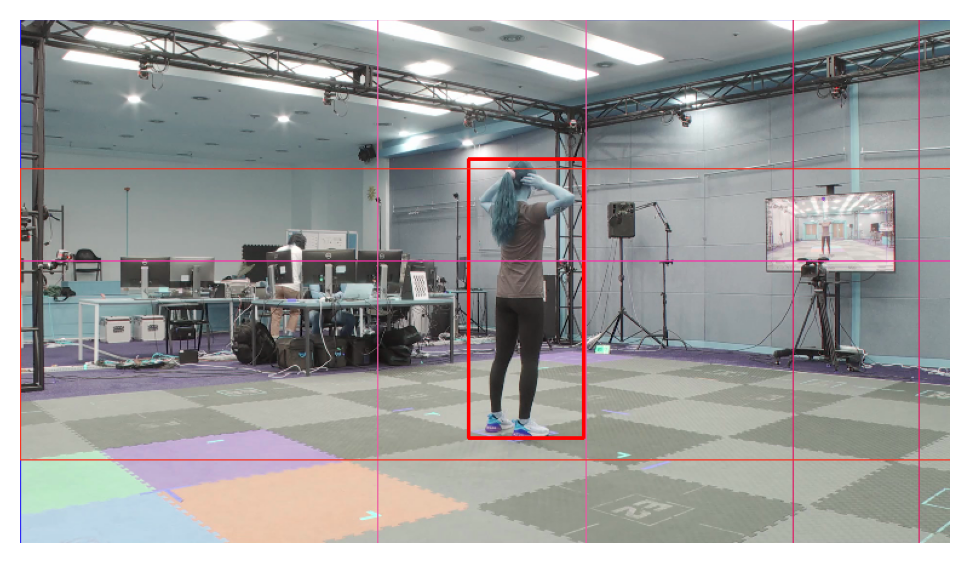

In [88]:
max_output_size = 5
colors = {k: tuple(map(int, np.random.randint(0, 255, 3))) for k in range(max_output_size)}
x1 = int(ground_truth_row['x_min'])
x2 = int(ground_truth_row['x_max'])
y1 = int(ground_truth_row['y_min'])
y2 = int(ground_truth_row['y_max'])

img_ = image.copy()
cv2.rectangle(img_, (x1, y1), (x2, y2), (255, 0, 0), thickness=2)

# selected_indices = tf.image.non_max_suppression(rois, ious, max_output_size=max_output_size, score_threshold=0.01)
selected_indices = tf.image.non_max_suppression(rois, ss, max_output_size=max_output_size, score_threshold=0.01)
anchors = tf.gather(rois, selected_indices)

for i, anchor in enumerate(anchors):
    anchor = anchor_to_coordinate(anchor.numpy())
    cv2.rectangle(
        img_, 
        (int(anchor[0]), int(anchor[2])), (int(anchor[1]), int(anchor[3])), 
        colors.get(i), 
        thickness=1
    )

fig, ax = plt.subplots(dpi=200)
ax.imshow(img_)
ax.axis('off')
plt.show()

In [170]:
rr = tf.convert_to_tensor(np.stack([rois, rois]))

In [140]:
rr = tf.expand_dims(tf.convert_to_tensor(rois), 0)

In [194]:
def non_max_suppression(boxes, overlapThresh=0.7):
    boxes = boxes.numpy()
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    
    pick = []
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]
        idxs = np.delete(
            idxs, 
            np.concatenate(([last], np.where(overlap > overlapThresh)[0]))
        )
        
    return boxes[pick]

In [189]:
tf.map_fn(fn=non_max_suppression, elems=rr)

<tf.Tensor: shape=(2, 2617, 4), dtype=float64, numpy=
array([[[272.18762207, 216.        , 138.56407166, 432.        ],
        [384.        , 216.        , 768.        , 432.        ],
        [413.59179688, 216.        , 104.        , 432.        ],
        ...,
        [384.        , 423.64855957, 768.        ,  16.70288086],
        [581.83837891,   8.24650574,  61.20373535,  16.49301147],
        [ 30.96367645,   8.09882736,  61.92735291,  16.19765472]],

       [[272.18762207, 216.        , 138.56407166, 432.        ],
        [384.        , 216.        , 768.        , 432.        ],
        [413.59179688, 216.        , 104.        , 432.        ],
        ...,
        [384.        , 423.64855957, 768.        ,  16.70288086],
        [581.83837891,   8.24650574,  61.20373535,  16.49301147],
        [ 30.96367645,   8.09882736,  61.92735291,  16.19765472]]])>

In [192]:
rr[0].shape

(4367, 4)

In [195]:
non_max_suppression(rr[0])

array([[272.18762207, 216.        , 138.56407166, 432.        ],
       [384.        , 216.        , 768.        , 432.        ],
       [413.59179688, 216.        , 104.        , 432.        ],
       ...,
       [384.        , 423.64855957, 768.        ,  16.70288086],
       [581.83837891,   8.24650574,  61.20373535,  16.49301147],
       [ 30.96367645,   8.09882736,  61.92735291,  16.19765472]])

In [196]:
non_max_suppression(rr[1])

array([[272.18762207, 216.        , 138.56407166, 432.        ],
       [384.        , 216.        , 768.        , 432.        ],
       [413.59179688, 216.        , 104.        , 432.        ],
       ...,
       [384.        , 423.64855957, 768.        ,  16.70288086],
       [581.83837891,   8.24650574,  61.20373535,  16.49301147],
       [ 30.96367645,   8.09882736,  61.92735291,  16.19765472]])

In [174]:
x1 = rr[:, :, 0]
y1 = rr[:, :, 1]
x2 = rr[:, :, 2]
y2 = rr[:, :, 3]

In [175]:
area = (x2 - x1 + 1) * (y2 - y1 + 1)

In [176]:
area

array([[ 38762.26568222,  83545.        ,  83545.        , ...,
         78460.74531555,  83545.        , -71279.00110245],
       [ 38762.26568222,  83545.        ,  83545.        , ...,
         78460.74531555,  83545.        , -71279.00110245]])

In [179]:
idxs = np.argsort(y2)

In [180]:
idxs

array([[3151,  175, 2727, ..., 2296, 2287,  270],
       [3151,  175, 2727, ..., 2296, 2287,  270]], dtype=int64)

In [121]:
pick = []
while len(idxs) > 0:
    last = len(idxs) - 1
    i = idxs[last]
    pick.append(i)

    xx1 = np.maximum(x1[i], x1[idxs[:last]])
    yy1 = np.maximum(y1[i], y1[idxs[:last]])
    xx2 = np.minimum(x2[i], x2[idxs[:last]])
    yy2 = np.minimum(y2[i], y2[idxs[:last]])

    w = np.maximum(0, xx2 - xx1 + 1)
    h = np.maximum(0, yy2 - yy1 + 1)

    overlap = (w * h) / area[idxs[:last]]
    idxs = np.delete(
        idxs, 
        np.concatenate(([last], np.where(overlap > overlapThresh)[0]))
    )

TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got <tf.Tensor: shape=(4367,), dtype=int32, numpy=array([3151,  175, 2727, ..., 4360, 4361, 4365])>

In [181]:
pick = []
last = len(idxs) - 1

In [182]:
i = idxs[last]
i

array([3151,  175, 2727, ..., 2296, 2287,  270], dtype=int64)

In [183]:
pick.append(i)
pick

[array([3151,  175, 2727, ..., 2296, 2287,  270], dtype=int64)]

In [184]:
xx1 = np.maximum(x1[i], x1[idxs[:last]])

IndexError: index 3151 is out of bounds for axis 0 with size 2

In [151]:
x1[i]

TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got <tf.Tensor: shape=(4367,), dtype=int32, numpy=array([3151,  175, 2727, ..., 4360, 4361, 4365])>

In [138]:
tf.gather_nd(x1, i)

InvalidArgumentError: index innermost dimension length must be <= params rank; saw: 4367 vs. 2 [Op:GatherNd]

In [75]:
scores, rps, _ = rpn(tf.keras.layers.Input(image.shape))

In [76]:
scores

<tf.Tensor 'rpn/cls_out/Reshape:0' shape=(None, 11664, 1) dtype=float32>

In [77]:
rps

<tf.Tensor 'rpn/stack:0' shape=(None, 11664, 4) dtype=float32>

In [78]:
def anchor_to_coordinate(boxes, size=(432, 768)):    
    x1 = boxes[:, :, 0] - boxes[:, :, 2]/2
    x2 = boxes[:, :, 0] + boxes[:, :, 2]/2
    y1 = boxes[:, :, 1] - boxes[:, :, 3]/2
    y2 = boxes[:, :, 1] + boxes[:, :, 3]/2
    
    x1 = tf.clip_by_value(x1, 0, size[1])
    x2 = tf.clip_by_value(x2, 0, size[1])
    y1 = tf.clip_by_value(y1, 0, size[0])
    y2 = tf.clip_by_value(y2, 0, size[0])
    return tf.stack([x1, x2, y1, y2], axis=-1)

In [79]:
def coordinate_to_anxhor(boxes):
    w = boxes[:, :, 1] - boxes[:, :, 0]
    h = boxes[:, :, 3] - boxes[:, :, 2]
    x = boxes[:, :, 0] + w/2
    y = boxes[:, :, 2] + h/2
    return tf.stack([x, y, w, h], axis=-1)

In [80]:
def get_rois(scores, rps, anchor_boxes):
    batch_size = scores.shape[0]

    gx = anchor_boxes[:, 0] + anchor_boxes[:, 2] * rps[:,:,0]
    gy = anchor_boxes[:, 1] + anchor_boxes[:, 3] * rps[:,:,1]
    gw = anchor_boxes[:, 2] * tf.exp(rps[:, :, 2])
    gh = anchor_boxes[:, 3] * tf.exp(rps[:, :, 3])
    rois = tf.stack([gx, gy, gw, gh], axis=2)
    rois = anchor_to_coordinate(rois)

    orders = tf.argsort(scores, axis=1)[:, ::-1, :]

    n_train_pre_nms = 3000
    orders = orders[:, :n_train_pre_nms]
    rois = tf.reshape(tf.gather(rois, orders, batch_dims=1), (-1, n_train_pre_nms, 4))
    rois = coordinate_to_anxhor(rois)
    return rois

In [81]:
rois = get_rois(scores, rps, anchor_boxes)
rois

<tf.Tensor 'stack_2:0' shape=(None, 3000, 4) dtype=float32>

In [82]:
def IoU(rois, gts):
    box1_area = tf.cast(rois[:, :, 2] * rois[:, :, 2], tf.float64)
    box2_area = tf.cast(gts[:,2] * gts[:,3], tf.float64)
    
    x1 = tf.maximum(tf.cast(rois[:, :, 0] - rois[:, :, 2]/2, tf.float64), tf.cast(tf.expand_dims(gts[:, 0] - gts[:, 2]/2, -1), tf.float64))
    x2 = tf.minimum(tf.cast(rois[:, :, 0] + rois[:, :, 2]/2, tf.float64), tf.cast(tf.expand_dims(gts[:, 0] + gts[:, 2]/2, -1), tf.float64))
    y1 = tf.maximum(tf.cast(rois[:, :, 1] - rois[:, :, 3]/2, tf.float64), tf.cast(tf.expand_dims(gts[:, 1] - gts[:, 3]/2, -1), tf.float64))
    y2 = tf.minimum(tf.cast(rois[:, :, 1] + rois[:, :, 3]/2, tf.float64), tf.cast(tf.expand_dims(gts[:, 1] + gts[:, 3]/2, -1), tf.float64))
    
    h = tf.maximum(tf.constant(0.0, dtype=tf.float64), y2 - y1 + 1.)
    w = tf.maximum(tf.constant(0.0, dtype=tf.float64), x2 - x1 + 1.)
    
    intersect = tf.math.multiply(h, w)
    union = tf.subtract(tf.add(box1_area, tf.expand_dims(box2_area, -1)), intersect)
    return tf.divide(intersect, union)

In [83]:
gts = tf.keras.layers.Input(shape=(4,))
ious = IoU(rois, gts)

## Detector

### Non-Maximum Suppression

In [84]:
def box_regression(boxes, gt):
    x, y, w, h = gt[0], gt[1], gt[2], gt[3]
    tx = (x - boxes[:, 0]) / (boxes[:, 2])
    ty = (y - boxes[:, 1]) / (boxes[:, 3])
    tw = tf.math.log(w / boxes[:, 2]) 
    th = tf.math.log(h / boxes[:, 3]) 
    return tf.transpose(tf.stack([tx, ty, tw, th]))

In [85]:
def NMS(rois, ious, GT, max_output_size=100):
    n_sample = 32
    pos_ratio = 0.25 
    n_pos = n_sample * pos_ratio
    pos_iou_thresh = 0.5 
    batch_size = 16
    if rois.shape[0]:
        batch_size = rois.shape[0]
    
    nmses = []
    for i in range(batch_size):
        selected_indices = tf.image.non_max_suppression(
            rois[i], 
            tf.cast(ious[i], tf.float32), 
            max_output_size=max_output_size, 
            score_threshold=1e-12, 
            iou_threshold=pos_iou_thresh
        )
        selected_anchors = tf.gather(rois[i], selected_indices)
        selected_ious = tf.gather(ious[i], selected_indices)

        pos_indices = tf.squeeze(tf.where(selected_ious >= pos_iou_thresh), -1)
        pos_anchors = tf.gather(selected_anchors, pos_indices) 

        neg_indices =tf.squeeze(tf.where(selected_ious < pos_iou_thresh), -1)
        neg_anchors = tf.gather(selected_anchors, neg_indices)
        
        labels = tf.reshape(tf.concat([tf.ones_like(pos_anchors)[:,0], tf.zeros_like(neg_anchors)[:,0]], axis=0)[:32], (-1, 1))
        nms = tf.concat([pos_anchors, neg_anchors], axis=0)[:32]
#         nms = box_regression(nms, GT[i])
        nms = tf.concat([nms, labels], axis=-1)
        nmses.append(nms)
    
    return tf.stack(nmses, axis=0)

In [86]:
nms = NMS(rois, ious, GT)
nms

<tf.Tensor 'stack_3:0' shape=(16, None, 5) dtype=float32>

### Regional Interest Projection

### RoI pooling

In [89]:
def anchor_to_anchor(boxes):    
    x1 = boxes[:, :, 0] - boxes[:, :, 2]/2
    y1 = boxes[:, :, 1] - boxes[:, :, 3]/2
    return tf.stack([y1, x1, boxes[:, :, 3], boxes[:, :, 2]], axis=-1)

In [90]:
def projection(nmses, feature_map):
    roi_projections_tensor = []
    for i in range(2):
        roi_projections = []
        for j in range(32):
            y, x, h, w = nmses[i, j]
            roi_projection = tf.image.crop_to_bounding_box(feature_map[i], y, x, h, w)
            roi_projection = tf.image.resize(roi_projection, size=(7, 13))
            roi_projections.append(roi_projection)
        roi_projections_tensor.append(tf.stack(roi_projections, axis=0))
    return tf.stack(roi_projections_tensor, axis=0)

In [91]:
def box_regression(boxes, gt):
    boxes = tf.cast(boxes, tf.float64)
    gt = tf.cast(gt, tf.float64)

    x = tf.reshape(gt[:, 0], (-1, 1))
    y = tf.reshape(gt[:, 1], (-1, 1))
    w = tf.reshape(gt[:, 2], (-1, 1))
    h = tf.reshape(gt[:, 3], (-1, 1))

    # x, y, w, h = gt[:, 0], gt[:, 1], gt[:, 2], gt[:, 3]
    tx = (x - boxes[:, :, 0]) / (boxes[:, :, 2])
    ty = (y - boxes[:, :, 1]) / (boxes[:, :, 3])
    tw = tf.math.log(w / boxes[:, :, 2]) 
    th = tf.math.log(h / boxes[:, :, 3]) 
    return tf.stack([tx, ty, tw, th], -1)

In [92]:
def NMS(rois, ious, GT, feature_map):
    n_sample = 32
    pos_ratio = 0.25 
    n_pos = n_sample * pos_ratio
    pos_iou_thresh = 0.5 
    
    batch_size = 16
    if rois.shape[0]:
        batch_size = rois.shape[0]

    nmses = []
    for i in range(batch_size):
        selected_indices = tf.image.non_max_suppression(
            rois[i], 
            tf.cast(ious[i], tf.float32), 
            max_output_size=100, 
            iou_threshold=pos_iou_thresh
        )
        selected_anchors = tf.gather(rois[i], selected_indices)
        selected_ious = tf.gather(ious[i], selected_indices)

        pos_indices = tf.squeeze(tf.where(selected_ious >= pos_iou_thresh), -1)
        pos_anchors = tf.gather(selected_anchors, pos_indices) 

        neg_indices =tf.squeeze(tf.where(selected_ious < pos_iou_thresh), -1)
        neg_anchors = tf.gather(selected_anchors, neg_indices)
        
        labels = tf.reshape(tf.concat([tf.ones_like(pos_anchors)[:,0], tf.zeros_like(neg_anchors)[:,0]], axis=0)[:32], (-1, 1))
        nms = tf.concat([pos_anchors, neg_anchors], axis=0)[:32]
        nms = tf.concat([nms, labels], axis=-1)
        nmses.append(nms)

    nmses = tf.stack(nmses, axis=0)
    labels = tf.expand_dims(nmses[:, :, -1], -1)
    nmses = nmses[:, :, :4]

    nmss = tf.cast(anchor_to_anchor(nmses)//2**4, tf.int32)
    roi_projections_tensor = projection(nmss, feature_map)
    bboxes_reg = box_regression(nmses, gts)

    return roi_projections_tensor, bboxes_reg, labels

In [93]:
feature_map = rpn.base_model(inputs)
roi_projections_tensor, bboxes_reg_labels, labels = NMS(rois, ious, gts, feature_map)

OperatorNotAllowedInGraphError: using a `tf.Tensor` as a Python `bool` is not allowed in Graph execution. Use Eager execution or decorate this function with @tf.function.

##  Classifier Network

### Label Generating

In [144]:
import numpy as np

def non_max_suppression(boxes, overlapThresh):
    if(len(boxes) == 0):
        raise ValueError('nonono')
        
    picked_class = []
    
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    print(idxs)
    
    pick = []
    
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        print(last, i)
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
        print('overlap : ',overlap)

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
        
        print('idx : ', idxs)

        # return only the bounding boxes that were picked using the
        # integer data type
    return boxes[pick].astype("int")

In [ ]:
def non_max_suppression(boxes, overlapThresh):
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    
    pick = []
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        print(last, i)
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
        
    return boxes[pick].astype("int")

In [146]:
236/292

0.8082191780821918

### Classifier 

In [ ]:
class Classifier(tf.keras.models.Model):
    def __init__(self, **kwargs):
        super(Classifier, self).__init__(**kwargs)
        self.fconv = tf.keras.layers.Conv2D(2048, 7, 13)
        self.reshape = tf.keras.layers.Reshape((-1,))
        self.dense1 = tf.keras.layers.Dense(2048)
        self.dense2a = tf.keras.layers.Dense(1, activation='sigmoid')
        self.dense2b = tf.keras.layers.Dense(4)
        
    def compile(self, optimizer):
        super(Classifier, self).compile()
        self.optimizer = optimizer
        self.loss_tracker = tf.keras.metrics.Mean(name='loss')
        self.test_loss_tracker = tf.keras.metrics.Mean(name='test_loss')
    
    def Cls_Loss(self, y_true, y_pred):
        return tf.losses.BinaryCrossentropy()(y_true, y_pred)

    def Reg_Loss(self, y_true, y_pred, indices):
        return tf.reduce_mean(tf.losses.Huber(reduction=tf.losses.Reduction.NONE)(y_true[indices], y_pred[indices]), axis=-1)
    
    def train_step(self, data):
        x, y = data
        y_cls = y[0]
        y_reg = y[1]
        indices = tf.reduce_any(tf.not_equal(y_cls, 0), axis=-1)
        rpn_lambda = 10
        
        with tf.GradientTape() as tape:
            cls, bbox_reg = self(x, training=True)
            cls_loss = self.Cls_Loss(y_cls, cls)
            reg_loss = self.Reg_Loss(y_reg, bbox_reg, indices)
            losses = cls_loss + rpn_lambda * reg_loss
            
        trainable_vars = self.trainable_variables
        grad = tape.gradient(losses, trainable_vars)
        self.optimizer.apply_gradients(zip(grad, trainable_vars))
        self.loss_tracker.update_state(losses)
        return {'classifier_loss': self.loss_tracker.result()}

    def test_step(self, data):
        x, y = data
        y_cls = y[0]
        y_reg = y[1]
        rpn_lambda = 5
        
        cls, bbox_reg, _ = self(x, training=False)
        cls_loss = self.Cls_Loss(y_cls, cls)
        reg_loss = self.Reg_Loss(y_reg, bbox_reg)
        losses = cls_loss + rpn_lambda * reg_loss

        self.test_loss_tracker.update_state(losses)
        return {'classifier_loss_val': self.test_loss_tracker.result()}

    def call(self, inputs, ):
        x = tf.keras.layers.TimeDistributed(self.fconv)(inputs)
        x = tf.keras.layers.TimeDistributed(self.reshape)(x)
        feature_vector = tf.keras.layers.TimeDistributed(self.dense1)(x)
        cls = tf.keras.layers.TimeDistributed(self.dense2a)(feature_vector)
        bbox = tf.keras.layers.TimeDistributed(self.dense2b)(feature_vector)
        return cls, bbox

In [1]:
(2406)/60

40.1

In [5]:
((236 * 2) * 11/8) * 6

31152

In [2]:
1180*16

18880

In [ ]:
18880


In [ ]:
classifier = Classifier()

classifier.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.0001)
)

In [ ]:
history = classifier.fit(
    x = roi_projections_tensor,
    y = (bboxes_reg, labels),
    epochs=5
)

## Faster R-CNN

In [ ]:
class Faster_RCNN(tf.kersa.Model):
    def __init__(self, anchor_boxes, **kwargs):
        super(Faster_RCNN, self).__init__(*kwargs)
        self.anchor_boxes = anchor_boxes
        self.rpn = RPN()
        self.roipooling = RoIPooling()
        self.classifier = Classifier()
        self.rpn_train = False
        self.classifier_train = False
        self.rpn_test = False
        self.classifier_test = False

    def compile(self, rpn_optimizer, classifier_optimizer):
        super(Faster_RCNN, self).compile()
        self.rpn.optimizer = optimizer
        self.classifier.optimizer = optimizer
        
    def train_step(self, data):
        x, y = data
        y_cls = y[0]
        y_reg = y[1]
        gts = y[2]
        
        if self.rpn_train:
            self.classifier.trainable = False
            self.rpn.trainable = True
            result = self.rpn.train_step(x, (y_cls, y_reg))
            
        if self.classifier_train:
            self.classifier.trainable = True
            self.rpn.trainable = False
            scores, rps, feature_map = self.rpn(x)
            rois = get_rois(scores, rps, self.anchor_boxes)
            ious = IoU(rois, gts)
            roi_projections_tensor, bboxes_reg_labels, labels = NMS(rois, ious, gts, feature_map)
            result = self.classifier.train_step(roi_projections_tensor, (labels, bboxes_reg_labels))
            
        return result
    
    def test_step(self, data):
        x, y = data
        y_cls = y[0]
        y_reg = y[1]
        gts = y[2]
        
        if self.rpn_test:
            result = self.rpn.test_step(x, (y_cls, y_reg))
        
        if self.classifier_test:
            scores, rps, feature_map = self.rpn(x)
            rois = get_rois(scores, rps, self.anchor_boxes)
            ious = IoU(rois, gts)
            roi_projections_tensor, bboxes_reg_labels, labels = NMS(rois, ious, feature_map)
            result = self.classifier.test_step(roi_projections_tensor, (labels, bboxes_reg_labels))

        return result
    
    def call(self, inputs, gts):
        scores, rps, feature_map = self.rpn(inputs)
        rois = get_rois(scores, rps, self.anchor_boxes)
        roi_projections_tensor = NMS(rois, feature_map)
        scores, bboxes = self.classifier(roi_projections_tensor)
        return scores, bboxes

In [ ]:
# ex) roi = (0.1, 0.2, 0.5, 0.5)
# feature_map.shape = (10, 10)

In [128]:
h_start = 1
w_start = 2
h_end = 5
w_end = 5

In [129]:
pooled_height = 10
pooled_width = 10

In [130]:
region_height = h_end - h_start
region_width = w_end - w_start

h_step = tf.cast(region_height / pooled_height, tf.int32)
w_step = tf.cast(region_width / pooled_width, tf.int32)

In [131]:
region_width

3

In [137]:
result_h[0][-1]

(<tf.Tensor: shape=(), dtype=int32, numpy=0>,
 <tf.Tensor: shape=(), dtype=int32, numpy=0>,
 <tf.Tensor: shape=(), dtype=int32, numpy=0>,
 3)

In [133]:
result_h = []
for i in range(pooled_height):
    result_w = []
    for j in range(pooled_width):
        result = (i*h_step, j*w_step, (i+1)*h_step if i+1 < pooled_height else region_height, (j+1)*w_step if j+1 < pooled_width else region_width)
        result_w.append(result)
    result_h.append(result_w)
        

In [141]:
class ROIPoolingLayer(tf.keras.layers.Layer):
    """ Implements Region Of Interest Max Pooling 
        for channel-first images and relative bounding box coordinates

        # Constructor parameters
            pooled_height, pooled_width (int) -- 
              specify height and width of layer outputs

        Shape of inputs
            [(batch_size, pooled_height, pooled_width, n_channels),
             (batch_size, num_rois, 4)]

        Shape of output
            (batch_size, num_rois, pooled_height, pooled_width, n_channels)

    """

    def __init__(self, pooled_height, pooled_width, **kwargs):
        self.pooled_height = pooled_height
        self.pooled_width = pooled_width

        super(ROIPoolingLayer, self).__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        """ Returns the shape of the ROI Layer output
        """
        feature_map_shape, rois_shape = input_shape
        assert feature_map_shape[0] == rois_shape[0]
        batch_size = feature_map_shape[0]
        n_rois = rois_shape[1]
        n_channels = feature_map_shape[3]
        return (batch_size, n_rois, self.pooled_height,
                self.pooled_width, n_channels)

    def call(self, x):
        """ Maps the input tensor of the ROI layer to its output

            # Parameters
                x[0] -- Convolutional feature map tensor,
                        shape (batch_size, pooled_height, pooled_width, n_channels)
                x[1] -- Tensor of region of interests from candidate bounding boxes,
                        shape (batch_size, num_rois, 4)
                        Each region of interest is defined by four relative 
                        coordinates (x_min, y_min, x_max, y_max) between 0 and 1
            # Output
                pooled_areas -- Tensor with the pooled region of interest, shape
                    (batch_size, num_rois, pooled_height, pooled_width, n_channels)
        """
        def curried_pool_rois(x):
            return ROIPoolingLayer._pool_rois(x[0], x[1],
                                              self.pooled_height,
                                              self.pooled_width)

        pooled_areas = tf.map_fn(curried_pool_rois, x, dtype=tf.float32)

        return pooled_areas

    @staticmethod
    def _pool_rois(feature_map, rois, pooled_height, pooled_width):
        """ Applies ROI pooling for a single image and varios ROIs
        """
        def curried_pool_roi(roi):
            return ROIPoolingLayer._pool_roi(feature_map, roi,
                                             pooled_height, pooled_width)

        pooled_areas = tf.map_fn(curried_pool_roi, rois, dtype=tf.float32)
        return pooled_areas

    @staticmethod
    def _pool_roi(feature_map, roi, pooled_height, pooled_width):
        """ Applies ROI pooling to a single image and a single region of interest
        """

        # Compute the region of interest
        feature_map_height = int(feature_map.shape[0])
        feature_map_width = int(feature_map.shape[1])

        h_start = tf.cast(feature_map_height * roi[0], 'int32')
        w_start = tf.cast(feature_map_width * roi[1], 'int32')
        h_end = tf.cast(feature_map_height * roi[2], 'int32')
        w_end = tf.cast(feature_map_width * roi[3], 'int32')

        region = feature_map[h_start:h_end, w_start:w_end, :]

        # Divide the region into non overlapping areas
        region_height = h_end - h_start
        region_width = w_end - w_start
        h_step = tf.cast(region_height / pooled_height, 'int32')
        w_step = tf.cast(region_width / pooled_width, 'int32')

        areas = [[(
            i*h_step,
            j*w_step,
            (i+1)*h_step if i+1 < pooled_height else region_height,
            (j+1)*w_step if j+1 < pooled_width else region_width
        )
            for j in range(pooled_width)]
            for i in range(pooled_height)]

        # take the maximum of each area and stack the result
        def pool_area(x):
            return tf.math.reduce_max(region[x[0]:x[2], x[1]:x[3], :], axis=[0, 1])

        pooled_features = tf.stack(
            [[pool_area(x) for x in row] for row in areas])
        return pooled_features

In [143]:
rrr = RoiPoolingConv()

TypeError: __init__() missing 2 required positional arguments: 'pool_size' and 'num_rois'

In [ ]:
class RegionOfInterest(tf.keras.layers.Layer):
    """
    ROI pooling layer proposed in Mask R-CNN (Kaiming He et. al.).

    :param size: Fixed size [h, w], e.g. [7, 7], for the output slices.
    :param stride: Integer, pooling stride.
    :return: slices: 5D Tensor (number of regions, slice_height,
    slice_width, channels)
    """
    def __init__(self, extent=(7, 7), strides=1, **kwargs):
        super(RegionOfInterest, self).__init__(**kwargs)
        self.channels = None
        self.extent = extent
        self.stride = strides
        
    def build(self, input_shape):
        super(RegionOfInterest, self).build(input_shape)
        self.channels = input_shape[1][3]

    def call(self, x, **kwargs):
        """
        :rtype: `(samples, proposals, width, height, channels)`
        """
        metadata, image, boxes = x[0], x[1], x[2]

        # convert regions from (x, y, w, h) to (x1, y1, x2, y2)
        boxes = tf.keras.backend.cast(boxes, tf.keras.backend.floatx())

        boxes = boxes / self.stride

        x1 = boxes[..., 0]
        y1 = boxes[..., 1]
        x2 = boxes[..., 2]
        y2 = boxes[..., 3]

        # normalize the boxes
        shape = metadata[0]

        h = tf.keras.backend.cast(shape[0], tf.keras.backend.floatx())
        w = tf.keras.backend.cast(shape[1], tf.keras.backend.floatx())

        x1 /= w - 1
        y1 /= h - 1
        x2 /= w - 1
        y2 /= h - 1

        x1 = tf.keras.backend.expand_dims(x1, axis=2)
        y1 = tf.keras.backend.expand_dims(y1, axis=2)
        x2 = tf.keras.backend.expand_dims(x2, axis=2)
        y2 = tf.keras.backend.expand_dims(y2, axis=2)

        boxes = tf.keras.backend.concatenate([y1, x1, y2, x2], axis=2)
        boxes = tf.keras.backend.reshape(boxes, (-1, 4))

        slices = tf.keras_rcnn.backend.crop_and_resize(image, boxes, self.extent)

        return tf.keras.backend.expand_dims(slices, axis=0)

    def compute_output_shape(self, input_shape):
        return 1, input_shape[2][1], self.extent[0], self.extent[1], self.channels

    def get_config(self):
        configuration = {
            "extent": self.extent,
            "strides": self.stride
        }
        return {**super(RegionOfInterest, self).get_config(), **configuration}


In [110]:
a = 10
w = 20get_base

In [105]:
w /= a - 1

In [111]:
w = w/(a - 1)

In [112]:
w

2.2222222222222223

In [ ]:
def get_base(img_size, model='vgg'):
    if model=='vgg':
        base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=img_size)
        feature_extractor = base_model.get_layer("block5_conv3")
    elif model == 'resnet':
        base_model = tf.keras.applications.ResNet101(include_top=False, weights='imagenet', input_shape=img_size)
        feature_extractor = base_model.get_layer("conv4_block23_out")
    else:
        raise Exception('vgg, resnet')
        
    base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=img_size)
    feature_extractor = base_model.get_layer("block5_conv3")
    base_model = tf.keras.models.Model(inputs=base_model.input, outputs=feature_extractor.output)
    return base_model

In [122]:
image1 = cv2.imread('./res/train_imgs/001-1-1-01-Z17_A-0000001.jpg', cv2.COLOR_BGR2RGB)
Ry = 0.4
Rx = 0.4
size = (int(image1.shape[0]*Ry), int(image1.shape[1]*Rx))
image1 = cv2.resize(image1, size[::-1])/255
inputs = tf.expand_dims(image1, 0)

In [127]:
base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=image1.shape)
feature_extractor = base_model.get_layer("block5_conv3")
base_model = tf.keras.models.Model(inputs=base_model.input, outputs=feature_extractor.output)

In [170]:
aa = base_model(inputs)

In [171]:
aa[0]

<tf.Tensor: shape=(27, 48, 1024), dtype=float32, numpy=
array([[[ 0.        ,  0.        ,  4.1569843 , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  2.9540195 ,  0.7995669 , ...,  0.646098  ,
          0.        ,  0.05000442],
        [ 0.7150445 ,  2.0643337 ,  0.        , ...,  0.9871703 ,
          1.7769597 ,  0.6042887 ],
        ...,
        [ 0.        ,  2.1230938 ,  0.        , ...,  0.30921328,
          2.686951  ,  1.486641  ],
        [ 0.73934156,  2.0625863 ,  0.        , ...,  0.7924062 ,
          2.4155467 ,  1.52583   ],
        [ 0.        ,  0.97952116,  0.        , ...,  0.50967455,
          2.377864  ,  0.8669274 ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        , 21.43652   , ...,  4.8439684 ,
          0.        ,  8.9515085 ],
        [ 0.        ,  2.593807  ,  0.        , ...,  0.        ,
          3.0664654 ,  1.9784901 ],
        ...

In [173]:
base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=image1.shape)
feature_extractor = base_model.get_layer("conv4_block6_out")
base_model = tf.keras.models.Model(inputs=base_model.input, outputs=feature_extractor.output)

In [172]:
nn = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=image1.shape)
nn.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 432, 768, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 438, 774, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 216, 384, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 216, 384, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [174]:
base_model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 432, 768, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 438, 774, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 216, 384, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 216, 384, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [151]:
base_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 432, 768, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 432, 768, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 432, 768, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 216, 384, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 216, 384, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 216, 384, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 108, 192, 128)    